# Best Predictive Model for Proteomics using a Transformer Model

## Task Type and Model Decision
This task is a regression task, where one type of omics data is predicted using others. Both VAEs and Transformers are suitable choices: VAEs excel with noisy data and handle missing values well, while Transformers are powerful for capturing complex interactions between features through their self-attention mechanism.

I selected a Transformer model because the multi-head attention can learn different types of relationships between omics data features and capturing various correlations that might exist. The self-attention mechanism allows the model to identify important feature interactions, which I think are important in multi-omics data integration. While VAEs would also be suitable, particularly for handling noise and missing values, the potential complex interactions between omics data features made Transformers my preferred choice.

## Data
The aim is to use multiple input omics datasets to predict proteomics data. Input omics data was selected by iteratively testing combinations to determine which best predicted proteomics. This indicated that transcriptomics data only as the optimal input combination for proteomics prediction (see EMBL_transformer_explore.ipynb).

## Plan
The approach follows a systematic comparison between a baseline MLP model and the Transformer architecture:

#### In EMBL_transformer_explore.ipynb
1. [Inspect data](#inspect-data);
2. [Create a simple MLP model](#baseline-mlp) as a baseline;
3. [Develop Transformer models](#transformer-models) with different fusion strategies and activation functions;
4. [Perform hyperparameter tuning](#hyperparameter-tuning);
5. [Conduct progressive input omics selection](#omics-selection);
6. [Create comprehensive loop](#evaluation-loop) to iterate through steps 3-5, obtaining metrics to determine the best Transformer model for comparison with the baseline MLP;

#### In EMBL_transformer_best_model.ipynb
7. [Select best-performing model](#best-performing);
8. [Analyse best-predicted proteomic features](#feature-analysis);

## Results
- The [baseline MLP model](#results-MLP) performed quite well already, with an R^2 ~0.83, an RMSE ~0.69, and prediction errors that are roughly Normally distributed.
- The best [Transformer model](#results-transformer) demonstrated that using transcriptomics data only as input omics data performed best, with R^2 ~0.83. However, rerunning the algorithm shows some variability in the best performing hyperparameters, such as fusion method selected. In addition, the Transformer model does not significantly outperform the baseline MLP model. Moving forward, cross-validation and improved data handling (e.g. outlier handling) would be worth exploring. 
- The results of the [feature analysis](#results-feature-analysis) showed significant correlation values >0.5 between the predicted and actual values. However, the R^2 values are low, indicating that while the general trends in protein expression are captured, the model does not accurately predict the exact values. 

## Future Work
Given more time, I would implement:

1. Cross-validation for more robust model evaluation;
2. Enhanced data handling, particularly for outliers. Despite the task stating the data was "processed and cleaned, so you can use them directly" I encountered outliers that might affect results. Going forward, I would address these outliers prior to modelling;
3. Development of ensemble methods to potentially improve prediction accuracy.



In [31]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import math
from IPython.display import display

In [32]:
# CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Select Best Performing Model <a id="best-performing"></a>

In [33]:
class ModularMultiOmicsTransformer(nn.Module):
    def __init__(self, input_dims, output_dim, num_heads=4, num_layers=6, 
                 hidden_dim=384, dropout_rate=0.1, fusion_method="gated",
                 activation_function="relu"):
        """
        Modular Transformer-based model with various fusion strategies and configurable activation
        
        Args:
            input_dims: Dictionary mapping omics type to its feature dimension
            output_dim: Number of proteomics features to predict
            fusion_method: One of ["hierarchical", "late", "gated", "weighted", "cross_attention"]
            activation_function: One of ["gelu", "relu"].
        """
        super(ModularMultiOmicsTransformer, self).__init__()
        
        self.fusion_method = fusion_method
        self.num_modalities = len(input_dims)
        
        # Get the specified activation function
        self.activation = self._get_activation_function(activation_function)
        
        # Create an embedding layer for each omics type
        self.embeddings = nn.ModuleDict({
            omics_type: nn.Sequential(
                nn.Linear(dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                self.activation
            ) for omics_type, dim in input_dims.items()
        })
        
        # Create separate transformer encoders for each modality
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout_rate,
            activation=activation_function,
            batch_first=True,
            norm_first=True
        )
        
        self.modality_transformers = nn.ModuleDict({
            omics_type: nn.TransformerEncoder(
                encoder_layer, 
                num_layers=2
            ) for omics_type in input_dims.keys()
        })
        
        # Generate positional encodings once
        self.register_buffer(
            "pos_encoding", 
            self._generate_positional_encoding(len(input_dims), hidden_dim)
        )
        
        # Type embeddings for all fusion methods
        self.type_embeddings = nn.Embedding(len(input_dims), hidden_dim)
        
        # Fusion-specific modules
        if fusion_method == "hierarchical":
            # For hierarchical fusion: modality -> joint processing
            self.joint_transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            
        elif fusion_method == "late":
            # For late fusion: process each modality separately, then combine
            self.fusion_layer = nn.Linear(hidden_dim * len(input_dims), hidden_dim)
            
        elif fusion_method == "gated":
            # For gated fusion: learn importance of each modality
            self.gate_networks = nn.ModuleDict({
                omics_type: nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    self.activation,
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.Sigmoid()
                ) for omics_type in input_dims.keys()
            })
            
        elif fusion_method == "weighted":
            # For weighted fusion: learn a weight for each modality
            self.modality_weights = nn.Parameter(torch.ones(len(input_dims)) / len(input_dims))
            self.softmax = nn.Softmax(dim=0)
            
        elif fusion_method == "cross_attention":
            # For cross-attention: joint transformer with attention pooling
            self.joint_transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            self.attention_pooling = nn.Sequential(
                nn.Linear(hidden_dim, 1),
                nn.Softmax(dim=1)
            )
        
        # Final prediction layers
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate/2),
        )
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self._init_weights()
    
    def _get_activation_function(self, name):
        """Return the activation function based on name"""
        activations = {
            "gelu": nn.GELU(),
            "relu": nn.ReLU(),
        }
        return activations.get(name.lower(), nn.GELU())
        
    def _generate_positional_encoding(self, seq_len, d_model):
        """Generate positional encodings for the Transformer"""
        pos_encoding = torch.zeros(1, seq_len, d_model)
        position = torch.arange(0, seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pos_encoding[0, :, 0::2] = torch.sin(position * div_term)
        pos_encoding[0, :, 1::2] = torch.cos(position * div_term)
        
        return pos_encoding
    
    def _init_weights(self):
        """Initialise weights using Xavier/Glorot initialisation"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, x_dict):
        """
        Forward pass
        
        Args:
            x_dict: Dictionary mapping omics type to tensor of shape [batch_size, features]
        """
        # Determine batch size of input data
        batch_size = next(iter(x_dict.values())).size(0)
        
        # Process each modality separately first
        modality_features = {}
        embedded_features = []
        modality_indices = []
        for i, (omics_type, x) in enumerate(x_dict.items()):
            
            # Embed to common dimension
            embedded = self.embeddings[omics_type](x)  # [batch_size, hidden_dim]
            embedded = embedded.unsqueeze(1)  # [batch_size, 1, hidden_dim]
            
            # Store for fusion methods that need individual modality features
            modality_features[omics_type] = embedded.squeeze(1)  # [batch_size, hidden_dim]
            
            # Store for fusion methods that need concatenated features
            embedded_features.append(embedded)
            modality_indices.append(i)
            
            # Process with modality-specific transformer if not using cross_attention
            if self.fusion_method != "cross_attention":
                transformed = self.modality_transformers[omics_type](embedded)
                # Squeeze to remove sequence dimension (only 1 token per modality)
                modality_features[omics_type] = transformed.squeeze(1)  # [batch_size, hidden_dim]
        
        # Apply fusion method
        if self.fusion_method == "hierarchical" or self.fusion_method == "cross_attention":
            # Concatenate along sequence dimension
            x = torch.cat(embedded_features, dim=1)  # [batch_size, num_omics, hidden_dim]
            
            # Add positional encoding and type embeddings
            type_ids = torch.tensor(modality_indices, device=x.device).expand(batch_size, -1)
            type_embeds = self.type_embeddings(type_ids)
            x = x + self.pos_encoding.to(x.device) + type_embeds
            
            # Apply joint transformer
            x = self.joint_transformer(x)  # [batch_size, num_omics, hidden_dim]
            
            if self.fusion_method == "hierarchical":
                # Take average of all modality representations
                fused = torch.mean(x, dim=1)  # [batch_size, hidden_dim]
            else:  # cross_attention
                # Use attention pooling
                attn_weights = self.attention_pooling(x)  # [batch_size, num_omics, 1]
                fused = torch.sum(x * attn_weights, dim=1)  # [batch_size, hidden_dim]
            
        elif self.fusion_method == "late":
            # Concatenate all modality features
            concatenated = torch.cat([
                modality_features[omics_type] for omics_type in x_dict.keys()
            ], dim=1)  # [batch_size, hidden_dim * num_omics]
            
            # Project back to hidden_dim
            fused = self.fusion_layer(concatenated)  # [batch_size, hidden_dim]
            
        elif self.fusion_method == "gated":
            # Apply gates to each modality
            gated_features = []
            for omics_type in x_dict.keys():
                gate = self.gate_networks[omics_type](modality_features[omics_type])
                gated = modality_features[omics_type] * gate
                gated_features.append(gated)
            
            # Sum all gated features
            fused = sum(gated_features)  # [batch_size, hidden_dim]
            
        elif self.fusion_method == "weighted":
            # Apply learned weights to each modality
            weights = self.softmax(self.modality_weights)
            
            weighted_sum = None
            for i, omics_type in enumerate(x_dict.keys()):
                if weighted_sum is None:
                    weighted_sum = weights[i] * modality_features[omics_type]
                else:
                    weighted_sum += weights[i] * modality_features[omics_type]
            
            fused = weighted_sum  # [batch_size, hidden_dim]
        
        # Final prediction
        features = self.fc_layers(fused)
        output = self.output_layer(features)
        
        return output


In [34]:
class MultiOmicsDataset(Dataset):
    def __init__(self, X_dict, y=None):
        self.X_dict = {k: torch.FloatTensor(v) for k, v in X_dict.items()}
        self.y = torch.FloatTensor(y) if y is not None else None
            
    def __len__(self):
        # Assuming all X datasets have the same length
        return len(next(iter(self.X_dict.values())))
        
    def __getitem__(self, idx):
        if self.y is not None:
            return {k: v[idx] for k, v in self.X_dict.items()}, self.y[idx]
        else:
            return {k: v[idx] for k, v in self.X_dict.items()}


In [35]:
def prepare_data_loaders(omics_set, datasets, test_size=0.2, batch_size=64, random_state=42):
    """
    Prepare data loaders for training, validation, and testing
    
    Parameters:
    -----------
    omics_set : list
        List of omics types to use
    datasets : dict
        Dictionary of DataFrames containing omics data
    test_size : float
        Proportion of data to use for testing
    batch_size : int
        Batch size for DataLoaders
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    train_loader : DataLoader
        DataLoader for training data
    val_loader : DataLoader
        DataLoader for validation data
    test_loader : DataLoader
        DataLoader for test data
    input_dims : dict
        Dictionary mapping each omics type to its dimensionality
    output_dim : int
        Dimensionality of the output (proteomics features)
    """
    from sklearn.model_selection import train_test_split
    
    # Get reference IDs from proteomics data
    reference_df = datasets["proteomics"]
    patient_id_col = reference_df.columns[0]
    reference_ids = list(reference_df[patient_id_col])
    
    # Extract omics data
    X_dict = {}
    for omics_type in omics_set:
        omics_df = datasets[omics_type]
        # Filter to reference IDs and exclude patient ID column
        omics_filtered = omics_df[omics_df[patient_id_col].isin(reference_ids)]
        X_dict[omics_type] = omics_filtered.iloc[:, 1:].values
    
    # Extract proteomics data (target)
    y = reference_df.iloc[:, 1:].values
    
    # Create input dimensions dictionary
    input_dims = {omics_type: X.shape[1] for omics_type, X in X_dict.items()}
    output_dim = y.shape[1]
    
    # Split data into train+val and test
    indices = np.arange(len(y))
    train_val_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=random_state
    )
    
    # Split train+val into train and validation
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=test_size, random_state=random_state
    )
    
    # Create train, validation, and test dictionaries
    train_X = {k: v[train_indices] for k, v in X_dict.items()}
    val_X = {k: v[val_indices] for k, v in X_dict.items()}
    test_X = {k: v[test_indices] for k, v in X_dict.items()}
    
    train_y = y[train_indices]
    val_y = y[val_indices]
    test_y = y[test_indices]
    
    # Create datasets and data loaders
    train_dataset = MultiOmicsDataset(train_X, train_y)
    val_dataset = MultiOmicsDataset(val_X, val_y)
    test_dataset = MultiOmicsDataset(test_X, test_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, input_dims, output_dim



In [36]:
def load_model(model_path, input_dims, output_dim, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Load the trained model from a .pth file
    
    Parameters:
    -----------
    model_path : str or Path
        Path to the saved model file
    input_dims : dict
        Dictionary mapping each omics type to its dimensionality
    output_dim : int
        Dimensionality of the output (proteomics features)
    device : str
        Device to load the model onto ("cuda" or "cpu")
        
    Returns:
    --------
    model : ModularMultiOmicsTransformer
        Loaded model
    """
    # Best parameters from results
    best_params = {
        "num_heads": 4,
        "num_layers": 6,
        "hidden_dim": 384,
        "dropout_rate": 0.1,
        "fusion_method": "gated",
        "activation_function": "relu"
    }
    
    # Create model instance with the best parameters
    model = ModularMultiOmicsTransformer(
        input_dims=input_dims,
        output_dim=output_dim,
        num_heads=best_params["num_heads"],
        num_layers=best_params["num_layers"],
        hidden_dim=best_params["hidden_dim"],
        dropout_rate=best_params["dropout_rate"],
        fusion_method=best_params["fusion_method"],
        activation_function=best_params["activation_function"]
    ).to(device)
    
    # Load the trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Set model to evaluation mode
    model.eval()
    
    return model



In [37]:
def predict_proteomics(model, data_loader, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Make predictions using the trained model
    
    Parameters:
    -----------
    model : ModularMultiOmicsTransformer
        Trained model
    data_loader : DataLoader
        DataLoader containing the input data
    device : str
        Device to use for inference
        
    Returns:
    --------
    predictions : numpy.ndarray
        Predicted proteomics values
    """
    model.eval()
    all_predictions = []
    
    with torch.no_grad():
        for inputs_dict in data_loader:
            # Handle different return types from DataLoader (with or without targets)
            if isinstance(inputs_dict, tuple):
                inputs_dict, _ = inputs_dict
                
            # Move inputs to device
            inputs_dict = {k: v.to(device) for k, v in inputs_dict.items()}
            
            # Get predictions
            outputs = model(inputs_dict)
            all_predictions.append(outputs.cpu().numpy())
    
    # Concatenate all batch predictions
    predictions = np.concatenate(all_predictions, axis=0)
    
    return predictions



In [38]:
def prepare_test_data(data, omics_set, batch_size=32):
    """
    Prepare test data for prediction
    
    Parameters:
    -----------
    data : dict
        Dictionary of DataFrames containing omics data
    omics_set : list
        List of omics types to use for prediction
    batch_size : int
        Batch size for the DataLoader
        
    Returns:
    --------
    data_loader : DataLoader
        DataLoader containing the test data
    input_dims : dict
        Dictionary mapping each omics type to its dimensionality
    """
    # Prepare input data dictionary
    X_dict = {}
    for omics_type in omics_set:
        if omics_type in data:
            # Exclude patient ID column (assuming it's the first column)
            X_dict[omics_type] = data[omics_type].iloc[:, 1:].values
        else:
            raise ValueError(f"Omics type '{omics_type}' not found in the provided data")
    
    # Create input dimensions dictionary
    input_dims = {omics_type: X.shape[1] for omics_type, X in X_dict.items()}
    
    # Create dataset and dataloader
    dataset = MultiOmicsDataset(X_dict)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    return data_loader, input_dims



In [39]:
def predict_with_best_model(data, model_path, proteomics_feature_names=None):
    """
    Use the best model to predict proteomics data
    
    Parameters:
    -----------
    data : dict
        Dictionary of DataFrames containing omics data
    model_path : str or Path
        Path to the saved model file
    proteomics_feature_names : list, optional
        List of feature names for the proteomics data
        
    Returns:
    --------
    predictions_df : DataFrame
        DataFrame containing the predicted proteomics values
    """
    
    # Best omics set from results
    best_omics_set = ["transcriptomics"]
    
    # Get sample IDs from transcriptomics data
    sample_ids = data["transcriptomics"].iloc[:, 0].values
    
    # Determine output dimension from proteomics data if available
    if "proteomics" in data:
        output_dim = data["proteomics"].shape[1] - 1  # Exclude patient ID column
    else:
        # Specify manually if proteomics data is not available
        output_dim = 100  # Replace with the actual number of proteomics features
    
    # Prepare test data
    data_loader, input_dims = prepare_test_data(data, best_omics_set)
    
    # Load model
    model = load_model(model_path, input_dims, output_dim, device)
    
    # Make predictions
    predictions = predict_proteomics(model, data_loader, device)
    
    # Create DataFrame with predictions
    if proteomics_feature_names is not None:
        columns = proteomics_feature_names
    else:
        columns = [f"protein_{i}" for i in range(predictions.shape[1])]
    
    predictions_df = pd.DataFrame(predictions, columns=columns)
    predictions_df.insert(0, "sample_id", sample_ids)
    
    return predictions_df

In [40]:
# Load data and create data paths
model_path = Path("models")
result_path = Path("results")
data_path_lung = Path("data")  # lung carcinoma data

# Check if the directories exist, and create them if they don't
if not model_path.exists():
    model_path.mkdir(parents=True)
if not result_path.exists():
    result_path.mkdir(parents=True)
if not data_path_lung.exists():
    data_path_lung.mkdir(parents=True)

# Load data
prefix = "20231023_092657_"
datasets = {
    "methylation": pd.read_csv(data_path_lung / f"{prefix}imputed_methylation.csv"),
    "metabolomics": pd.read_csv(data_path_lung / f"{prefix}imputed_metabolomics.csv"),
    "proteomics": pd.read_csv(data_path_lung / f"{prefix}imputed_proteomics.csv"),
    "transcriptomics": pd.read_csv(data_path_lung / f"{prefix}imputed_transcriptomics.csv"),
    "cnv": pd.read_csv(data_path_lung / f"{prefix}imputed_copynumber.csv"),
}

# Get the patient ID column name
patient_id_col = list(datasets.values())[0].columns[0]

# Reference/Target dataset, i.e. proteomics
reference = "proteomics"
reference_df = datasets[reference]
reference_ids = list(reference_df[patient_id_col])

# Get proteomics feature names (excluding the ID column)
proteomics_features = datasets["proteomics"].columns.tolist()[1:]

# Best model parameters
best_params = {
    "num_heads": 4,
    "num_layers": 6,
    "hidden_dim": 384,
    "dropout_rate": 0.1,
    "fusion_method": "gated",
    "activation_function": "relu"
}

# Best omics set from results
best_omics_set = ["transcriptomics"]

# Check if model exists, if not, we would train it
model_file = model_path / "best_model_transcriptomics.pth"
if not model_file.exists():
    print(f"Model file {model_file} does not exist. Please train the model first.")
    # Here we would add training code if needed
else:
    print(f"Model found at {model_file}")

# Make predictions
print("\nMaking proteomics predictions...")
predictions_df = predict_with_best_model(datasets, model_file, proteomics_features)

# Save predictions
predictions_df.to_csv(result_path / "predicted_proteomics.csv", index=False)
print(f"Predictions saved to {result_path / 'predicted_proteomics.csv'}")

predictions_df

Model found at models/best_model_transcriptomics.pth

Making proteomics predictions...
Predictions saved to results/predicted_proteomics.csv


,sample_id,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AARS1,AARS2,AARSD1,...,ZNF830,ZNHIT2,ZNRD2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX
0,SIDM00046,3.430683,2.362924,3.130981,2.735449,2.340763,2.855073,5.503754,3.648705,3.007615,...,0.680787,2.001088,4.120939,3.192780,3.472687,4.241448,2.530603,1.905977,2.052303,3.747846
1,SIDM00047,3.430691,2.362929,3.130991,2.735459,2.340774,2.855051,5.503782,3.648698,3.007621,...,0.680795,2.001120,4.120911,3.192799,3.472691,4.241487,2.530591,1.905953,2.052305,3.747873
2,SIDM00048,3.430688,2.362927,3.130990,2.735454,2.340777,2.855056,5.503772,3.648706,3.007621,...,0.680790,2.001115,4.120920,3.192795,3.472696,4.241483,2.530599,1.905959,2.052301,3.747877
3,SIDM00098,3.430700,2.362946,3.130997,2.735450,2.340769,2.855044,5.503774,3.648697,3.007607,...,0.680792,2.001122,4.120915,3.192791,3.472690,4.241486,2.530577,1.905947,2.052297,3.747880
4,SIDM00099,3.430696,2.362945,3.130996,2.735448,2.340769,2.855044,5.503778,3.648697,3.007612,...,0.680787,2.001123,4.120912,3.192793,3.472692,4.241496,2.530583,1.905943,2.052301,3.747885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,SIDM01149,3.430744,2.362959,3.130988,2.735454,2.340769,2.855047,5.503748,3.648649,3.007534,...,0.680828,2.001126,4.120930,3.192748,3.472683,4.241390,2.530480,1.905969,2.052262,3.747825
171,SIDM01150,3.430691,2.362907,3.130997,2.735455,2.340789,2.855056,5.503796,3.648693,3.007626,...,0.680785,2.001123,4.120913,3.192804,3.472702,4.241499,2.530588,1.905949,2.052309,3.747885
172,SIDM01156,3.430706,2.362941,3.130994,2.735446,2.340767,2.855046,5.503781,3.648692,3.007607,...,0.680780,2.001125,4.120912,3.192791,3.472689,4.241497,2.530579,1.905951,2.052295,3.747875
173,SIDM01163,3.430693,2.362942,3.130990,2.735456,2.340765,2.855042,5.503776,3.648689,3.007611,...,0.680783,2.001115,4.120912,3.192790,3.472679,4.241488,2.530581,1.905949,2.052298,3.747869


# Feature Analysis <a id="feature-analysis"></a>

NOTE: this part is also in the EMBL_transformer_explore.ipynb

Look at best predicting proteomic features.

In [41]:
# Feature-level analysis
def analyse_feature_level_performance(best_omics_set, best_params, datasets, model_path, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Analyse which individual genes/features were predicted best by the model
    
    Parameters:
    -----------
    best_omics_set : list
        The best combination of omics types
    best_params : dict
        Best hyperparameters for the model
    datasets : dict
        Dictionary of DataFrames containing omics data
    model_path : Path
        Path to the model directory
        
    Returns:
    --------
    feature_metrics : pd.DataFrame
        DataFrame with performance metrics for each feature
    """
    print(f"\n{'-'*80}")
    print(f"Analysing feature-level performance for best model: {best_omics_set}")
    print(f"{'-'*80}")
    
    # Prepare data loaders
    train_loader, val_loader, test_loader, input_dims, output_dim = prepare_data_loaders(
        best_omics_set, datasets, test_size=0.2, batch_size=64
    )
    
    # Get the feature names from the proteomics data
    target_feature_names = datasets["proteomics"].columns.tolist()[1:]  # Skip the ID column
    
    # Separate out parameters from model vs. training process 
    model_params = {k: v for k, v in best_params.items() if k not in ["learning_rate", "weight_decay", "batch_size", "epochs"]}
    model = ModularMultiOmicsTransformer(
        input_dims=input_dims,
        output_dim=output_dim,
        **model_params
    ).to(device)
    
    # Load the best model weights
    model_name = f"best_model_{'_'.join(best_omics_set)}.pth"
    model.load_state_dict(torch.load(model_path / model_name))
    model.eval()
    
    # Collect predictions and targets
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs_dict, targets in test_loader:
            inputs_dict = {k: v.to(device) for k, v in inputs_dict.items()}
            targets = targets.to(device)
            
            outputs = model(inputs_dict)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Calculate metrics for each feature
    feature_metrics = []
    for i in range(output_dim):
        y_true = all_targets[:, i]
        y_pred = all_predictions[:, i]
        
        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        corr, p_value = pearsonr(y_true, y_pred)
        
        # Store in dictionary
        feature_metrics.append({
            "Feature": target_feature_names[i] if i < len(target_feature_names) else f"Feature_{i}",
            "R2": r2,
            "RMSE": rmse,
            "MAE": mae,
            "Correlation": corr,
            "P_value": p_value
        })
    
    # Sort by R2 (descending)
    feature_metrics = pd.DataFrame(feature_metrics)
    feature_metrics = feature_metrics.sort_values("R2", ascending=False)
    feature_metrics.to_csv("feature_level_performance.csv", index=False)
    
    # Display top and bottom performing features
    print("\nTop 10 best predicted features:")
    display(feature_metrics.head(10))
    
    print("\nBottom 10 worst predicted features:")
    display(feature_metrics.tail(10))
    
    # Plot distribution of R2 scores
    plt.figure(figsize=(12, 6))
    plt.hist(feature_metrics["R2"], bins=50, alpha=0.7)
    plt.axvline(feature_metrics["R2"].mean(), color="red", linestyle="--", 
                label=f"Mean R² = {feature_metrics['R2'].mean():.4f}")
    plt.axvline(feature_metrics["R2"].median(), color="green", linestyle="--", 
                label=f"Median R² = {feature_metrics['R2'].median():.4f}")
    plt.title("Distribution of R² Scores Across Features")
    plt.xlabel("R² Score")
    plt.ylabel("Number of Features")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()
    
    # Plot a few example scatter plots for best and worst features
    num_plots = min(3, len(feature_metrics))
    plt.figure(figsize=(15, 5))
    
    # Best features
    for i in range(num_plots):
        plt.subplot(1, num_plots, i+1)
        feature = feature_metrics.iloc[i]["Feature"]
        idx = target_feature_names.index(feature) if feature in target_feature_names else i
        
        plt.scatter(all_targets[:, idx], all_predictions[:, idx], alpha=0.5)
        plt.plot([min(all_targets[:, idx]), max(all_targets[:, idx])], 
                 [min(all_targets[:, idx]), max(all_targets[:, idx])], "r--")
        plt.title(f"{feature}\nR² = {feature_metrics.iloc[i]['R2']:.4f}")
        plt.xlabel("True Value")
        plt.ylabel("Predicted Value")
    
    plt.tight_layout()
    plt.show()
    
    return feature_metrics


Analysing feature-level performance...

--------------------------------------------------------------------------------
Analysing feature-level performance for best model: ['transcriptomics']
--------------------------------------------------------------------------------


/tmp/ipykernel_2808979/2905733847.py:72: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, p_value = pearsonr(y_true, y_pred)
/tmp/ipykernel_2808979/2905733847.py:72: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, p_value = pearsonr(y_true, y_pred)
/tmp/ipykernel_2808979/2905733847.py:72: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, p_value = pearsonr(y_true, y_pred)
/tmp/ipykernel_2808979/2905733847.py:72: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, p_value = pearsonr(y_true, y_pred)
/tmp/ipykernel_2808979/2905733847.py:72: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, p_value = pearsonr(y_true, y_p


Top 10 best predicted features:


,Feature,R2,RMSE,MAE,Correlation,P_value
2587,NBAS,0.000237,0.333540,0.260252,0.582853,0.000239
2425,MRPL18,0.000203,0.437633,0.347377,0.614880,0.000085
2430,MRPL23,0.000201,0.482791,0.391983,0.650734,0.000023
2548,MYO1B,0.000142,0.609084,0.485759,0.525912,0.001176
2976,PDIA6,0.000129,0.480627,0.379363,0.603052,0.000126
4675,UQCRC1,0.000129,0.576798,0.476663,0.593700,0.000170
1428,FBXO22,0.000123,0.358574,0.295139,0.548903,0.000639
4795,WDR75,0.000122,0.345262,0.271033,0.494660,0.002522
2862,OS9,0.000116,0.606212,0.478487,0.688038,0.000005
3298,PRPSAP1,0.000094,0.523188,0.404732,0.361332,0.032951



Bottom 10 worst predicted features:


,Feature,R2,RMSE,MAE,Correlation,P_value
4089,SPATS2L,-0.232327,0.801084,0.665394,0.250899,0.146001
3360,PSPH,-0.241867,0.915077,0.665961,-0.440087,0.008155
2223,LYRM7,-0.267294,0.496454,0.398635,0.048093,0.783816
602,CCN1,-0.268506,0.653079,0.535651,0.336736,0.047929
494,C17orf75,-0.290804,0.284711,0.232540,0.194283,0.263419
1169,DUS2,-0.291980,0.346978,0.272138,-0.053347,0.760854
907,CRYZL1,-0.299547,0.397953,0.310647,-0.244511,0.156892
34,ABRACL,-0.331639,0.795652,0.616579,0.322597,0.058747
3587,RHOB,-0.337894,0.645801,0.538274,0.286626,0.095048
410,BAP18,-0.370346,0.640315,0.456278,-0.283017,0.099472


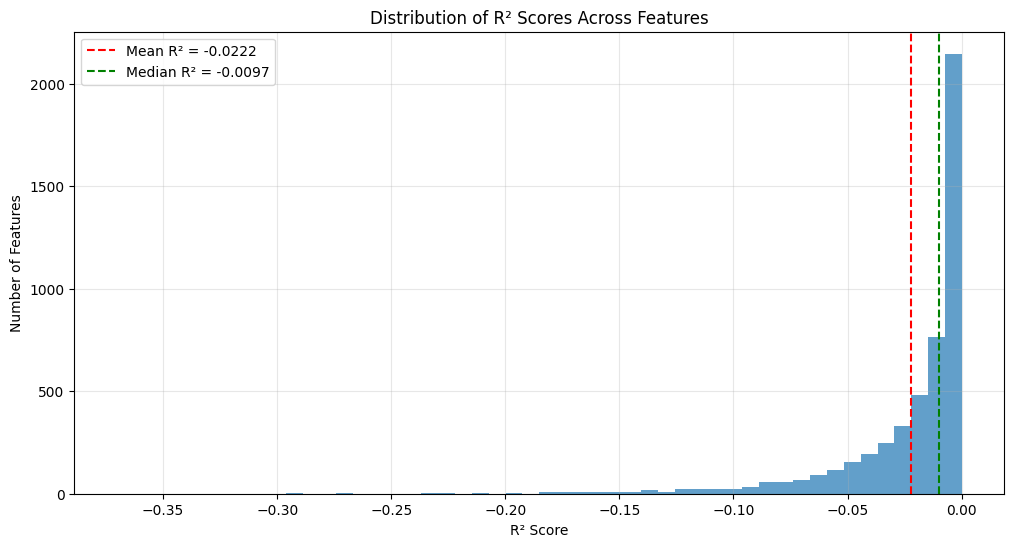

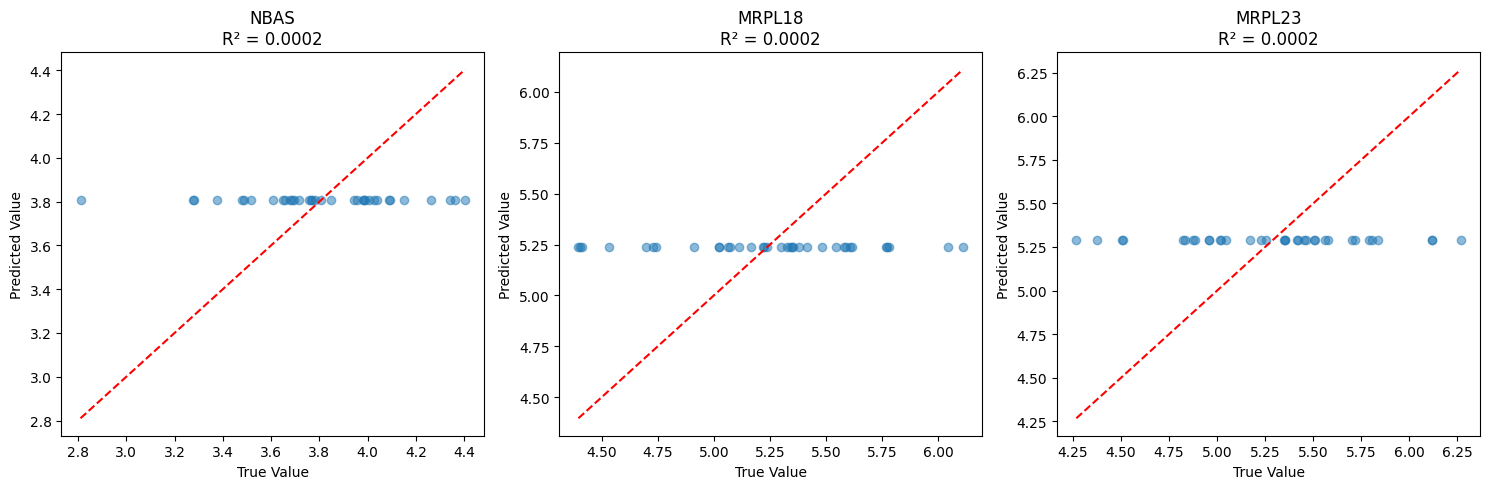

Feature performance metrics saved to results/feature_performance_metrics.csv


,Feature,R2,RMSE,MAE,Correlation,P_value
2587,NBAS,0.000237,0.333540,0.260252,0.582853,0.000239
2425,MRPL18,0.000203,0.437633,0.347377,0.614880,0.000085
2430,MRPL23,0.000201,0.482791,0.391983,0.650734,0.000023
2548,MYO1B,0.000142,0.609084,0.485759,0.525912,0.001176
2976,PDIA6,0.000129,0.480627,0.379363,0.603052,0.000126
...,...,...,...,...,...,...
1169,DUS2,-0.291980,0.346978,0.272138,-0.053347,0.760854
907,CRYZL1,-0.299547,0.397953,0.310647,-0.244511,0.156892
34,ABRACL,-0.331639,0.795652,0.616579,0.322597,0.058747
3587,RHOB,-0.337894,0.645801,0.538274,0.286626,0.095048


In [42]:
# Analyse feature-level performance
print("\nAnalysing feature-level performance...")
feature_performance = analyse_feature_level_performance(
    best_omics_set, 
    best_params, 
    datasets, 
    model_path,
    device
)

# Save feature performance metrics
feature_performance.to_csv(result_path / "feature_performance_metrics.csv", index=False)
print(f"Feature performance metrics saved to {result_path / 'feature_performance_metrics.csv'}")

feature_performance

# Best Predicting Protein Features <a id="results-feature-analysis"></a>

The results that the best predicting proteomic features actually have very low R^2 values, which indicates weak prediction performance and not a lot of variability is explained. The correlation values between the predicted and actual values >0.5 with significant p-values, so the model seems to capture some meaningful relationship between input omics data and protein expression, but not strongly. 


The disconnect between the correlation values and the very low R^2 values suggests that while the model is capturing some general trends in protein expression (hence the correlations), it's not accurately predicting the exact values (hence the poor R^2 values). This could be due to scaling issues in the predictions or systematic biases that the model hasn't learned to correct.


The RMSE values are consistently higher than MAE, suggesting some (larger) errors in the predictions. This because RMSE is more sensitive to outliers (quadratic penalty).